## Neural Networks Learning for Digital Image Recognition
This project implemented a three layer neural networks for digital image recognition. The networks consists of an input layer, one hidden layer and one output layer. The dataset contains 5000 digit images. Each corresponds to a 20 pixel by 20 pixel grayscale image of the digit (0-9). Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels have been converted to a 400-dimentional vector. The labels of the images are stored in another txt file, in which digit 0 is label as 10. For all the other digits from 1-9, labels and the digit images are consistent. This digit image dataset was splited into training and test datasets for the training and evaluation of the neural networks built in this project. Prediction accuray on the test dataset was used to evaluate the model. An accuracy of 0.939 was obtained on test dataset, with an optimum l2 lambda value of 1.5

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
from scipy.special import expit
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

### Load and Explore Data

First, we load the digital image and label data. Since the digit image of 0 is labeled as 10 in the target_y, we convert the number 10 to 0. 

In [2]:
image_X=pd.read_csv("ex4data1X.txt",header=None).values
target_y=pd.read_csv("ex4dataY.txt",header=None)

target_y=target_y[0]

target_y[target_y==10]=0


Now, we will check the distribution of the label counts. 

In [3]:
target_y.value_counts()

7    500
3    500
6    500
2    500
9    500
5    500
1    500
8    500
4    500
0    500
Name: 0, dtype: int64

We can see that the 9 digit numbers are evenly distributed in the total 5000 images, with each number having 500 images. Now we can check some of the digit images.

Now, we convert target_y from pandas Series to numpy array for model fitting.

In [4]:
target_y=target_y.values

Let's check some of the digit images stored in image_X:

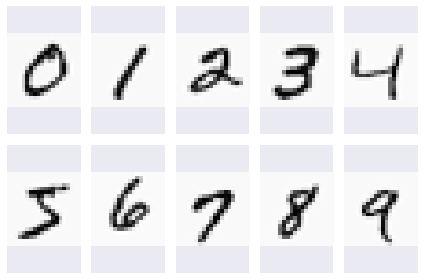

In [5]:
fig, ax=plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(10):
    img=image_X[target_y==i,:][0].reshape(20,20).T
    #img=ndimage.rotate(img,-90)
    ax[i].imshow(img,cmap="Greys",interpolation="nearest")
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()    

It woruld be interesing to see the different styles of the same digit number. Let' check the different styles for digit number 9:

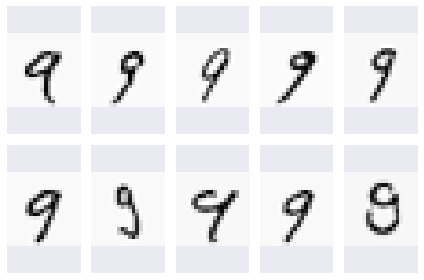

In [6]:
fig, ax=plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(10):
    img=image_X[target_y==9,:][i].reshape(20,20).T
    ax[i].imshow(img,cmap="Greys",interpolation="nearest")
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()      

### Implementation of Neural Networks

In this section, we will implement a simple nerual networks using the feedforward and backpropagation algorithms. Below is a very concise explanation of functions implemented in the model. For the details of the derivation of the equations and algorithm implementation considerations, please refer to the [Neural Networks Learning]( http://htmlpreview.github.io/?https://github.com/yuanDataScience/Machine_Learning_R/blob/master/NeuralNetworksLearning/Neural_Networks_Learning.nb.html) project in my github.
It should be noted that the purpose of this project is to help people to understand the feed forward and back propagation algorithms. Therefore, the implementation is very slow when training large nerual networks and large datasets. The model can not be used for big datasets such as the MNIST digital image datasets.  

The neural networks model implemented the following functions:
    1. __init__(): function that initializes an instance of a neural networks model, and defines the network structure and hyperparameter (lmd for the l2 regularization)
    2. _costCompute() and _gradCompute(): functions that calculate the cost and gradient of weight parameters using feed forward and back propagation alogrithms, respectively
    3. _randomInitializeWeights(): function that generates the initial networks paramters based on uniform distribution
    4 _debugInitializeWeights(): This function is used for testing and debugging. Given the numbers of neurons in the neighboring two layers, the function generates simulated weight parameters connecting the two layers using sine function. By using this function, we can establish small size simulated neural networks containing only a few neurons in each layer with the corresponding weight parameters. Network weight gradients calculated by back propagation and numeric methods for this simulated neural networks can be compared to check if the back propagation algorithm is properly implemented. 
    5. _computeNumericGrad(): This function calculates the gradient using the numerical method by introducing a small disturbance to each weight parameter and calculates the diffence in cost function divided by the magnitude of the disturbance. It can only be used on small neural network. It is used in this project to check if the back propagation algorithm is properly implemented.
    6. checkNNGradients(): This function creates a small, simulated neural networks using __debugInitializeWeights(), and compares the gradient of weight parameters obtained by numerical and back propagration algorithms.
    7. fit(): trains the neural networks by optimizing the weight parameters using the training dataset
    8. predict(): predicts the target variables using the trained neural networks model.

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
class ann(BaseEstimator,ClassifierMixin):
    def __init__(self,lmd=1,input_layer_size=400,hidden_layer_size=25,number_labels=10):
        self.lmd=float(lmd)
        self.input_layer_size=input_layer_size
        self.hidden_layer_size=hidden_layer_size
        self.number_labels=number_labels
        
    def _costCompute(self,theta,X,y):
        '''
        This function calculates the cost function based on the feed forward algorithm
        input
           theta: vector including network parameters from input to hidden, and from hidden to output layer
           X: feaature matrix, exclusive of the intercept
           y: target variable vector
           
        output
           The cost of the output layer calculated by feedforward algorithm
        '''
        # get the sizes of the parameters from input to hidden layer (t1_element)
        t1_element=(self.input_layer_size+1)*self.hidden_layer_size 
        t2_start_idx=t1_element
        num_obs=X.shape[0]
        
        t1=theta[:t1_element].reshape((self.hidden_layer_size,-1)) #hidden_layer_size * input_layer_size+1
        t2=theta[t2_start_idx:].reshape((self.number_labels,-1)) #number_labels * hidden_layer_size+1
        
        intercept=np.ones((num_obs,1))
        X=np.hstack((intercept,X))
        h=expit(np.hstack((intercept,expit(X.dot(t1.T)))).dot(t2.T))
        
        onehot=np.zeros((num_obs,self.number_labels))
        for idx, label in enumerate(y):
            onehot[idx,label]=1.0
            
        lld=onehot*np.log(h)+(1-onehot)*np.log(1-h)    
            
        return -1.0/num_obs*lld.sum() +0.5*(self.lmd/num_obs)*((t1[:,1:]*t1[:,1:]).sum()+(t2[:,1:]*t2[:,1:]).sum())
    
    def _gradCompute(self,theta,X,y):
        '''
        This function calculates the gradient of weight parameters, theta, using back propogation algorithm
        input
           theta: vector including network parameters from input to hidden, and from hidden to output layer
           input_layer_size: the number of features in input matrix
           hidden_layer_size: the number of nodes in the hidden layer
           number_labels: the number of the labels, in this project is 10. This also equals the number of output layer nodes
           X: feaature matrix, exclusive of the intercept
           y: target variable vector
           lmd: lambda hyper-parameter defining regularization
        output
           The gradient of network parameters as a vector
        '''
        t1_element=(self.input_layer_size+1)*self.hidden_layer_size
        t2_start_idx=t1_element
        
        num_obs=X.shape[0]
       
        t1=theta[:t1_element].reshape((self.hidden_layer_size,-1)) # hidden_layer_size*input_layer_size+1
        t2=theta[t2_start_idx:].reshape((self.number_labels,-1)) #number_labers*(hidden_layer_size+1)
        onehot=np.zeros((num_obs,self.number_labels))
        for idx, label in enumerate(y):
            onehot[idx,label]=1.0
            
        intercept=np.ones((num_obs,1))
        X=np.hstack((intercept,X))
        
        X_middle_pred=expit(X.dot(t1.T)) # num_obs*hidden_layer_size prediction
        
        output_layer=expit(np.hstack((intercept,X_middle_pred)).dot(t2.T)) #num_obs*number_label
        delta_output_layer=output_layer-onehot #num_obs*number_label
        
        
        error_transfer_middle=delta_output_layer.dot(t2[:,1:]) #num_obs*hidden_layer_size
        delta_middle=error_transfer_middle*X_middle_pred*(1-X_middle_pred) #num_obs*hidden_layer_size
        
        grad_t2=(1.0/num_obs)*delta_output_layer.T.dot(np.hstack((intercept,X_middle_pred)))
        grad_t2[:,1:]+=(self.lmd/num_obs)*t2[:,1:]
        
        grad_t1=(1.0/num_obs)*delta_middle.T.dot(X)
        grad_t1[:,1:]+=(self.lmd/num_obs)*t1[:,1:]
        
        return np.concatenate((grad_t1.ravel(),grad_t2.ravel()))
       
    
    
    def _randInitializeWeights(self,L_in, L_out):
        '''
        This function initialize the weight parameters connecting two neighboring layers
        , given the number of nodes in input and outpur layers. 
        '''
        epsilon_init=0.12
        w=(np.random.uniform(size=(L_in+1)*L_out)*epsilon_init*2-epsilon_init).reshape((L_out,L_in+1))
        return(w)
    
    def _computeNumericGrad(self,theta,X, y):
        '''
        This function calculates the gradient of weight parameters, theta, using numeric difference in the cost function,
        given very small change (1e-4) in each weight parameter. This function is used to check if _gradCompute() function
        is correctly implemented.
        input
           theta: vector including network parameters from input to hidden, and from hidden to output layer
           input_layer_size: the number of features in input matrix
           hidden_layer_size: the number of nodes in the hidden layer
           number_labels: the number of the labels, in this project is 10. This also equals the number of output layer nodes
           X: feaature matrix, exclusive of the intercept
           y: target variable vector
           lmd: lambda hyper-parameter defining regularization
        output
           The gradient of network parameters as a vector
        '''
        para_size=len(theta)
        e=1e-4
        num_grad=np.zeros(para_size)
        disturb=np.zeros(para_size)
        for idx in range(para_size):
            disturb[idx]=e
            loss1=self._costCompute(theta-disturb,X,y)
            loss2=self._costCompute(theta+disturb,X,y)
            num_grad[idx]=(loss2-loss1)/(2*e)
            disturb[idx]=0.0
            
        return num_grad
    
    def _debugInitializeWeights(self,fout,fin):
        '''
        This function is used for debugging. It is used in this project to check if the _gradCompute() function
        is correctly implemented using the network weight parameters generated by this function.
        
        This function generates the simulated network weight parameters, given the numbers of nodes 
        in input and output layers of the neighboring layers using sine function. As a result, for
        every neighboring layers in the network with a fixed numbers of input and output layer nodes,
        the function will generate the corresponding simulated weight paramters connecting these two layers.
        
        input
           fout: the number of nodes in the output layer of the two neighboring layers
           fin: the number of nodes in the input layer of the two neighboring layers.
        
        '''
        total_element=fout*(fin+1)
        w=np.sin(np.arange(1,total_element+1)).reshape((fout,fin+1))
        return w
        
    
    def checkNNGradients(self,lmd=0):
        '''
        This function checks if the gradient of weight parameters are correctly calcualted by _gradCompute() function by
        comparing the networks weight parameter gradient obtained using numeric method (_computeNumericGrad) and 
        back propogation algorithm (_gradCompute()) using a small simulated neural network and input data generated by 
        _debugInitializedWeights() function.
        
        input
           lmd: lambda value for regularized logistic regression
           
        output:
            prints normalized difference between the gradient calculated by numerica and back propogation algorithms.
            returns the gradients calculated by the two algorithms as pandas dataframe.
        
        '''
        self.lmd=float(lmd)
        self.input_layer_size=3
        self.hidden_layer_size=5
        self.number_labels=3
        m=5
        
        Theta1=self._debugInitializeWeights(self.hidden_layer_size,self.input_layer_size)
        Theta2=self._debugInitializeWeights(self.number_labels,self.hidden_layer_size)
        
        feature_X=self._debugInitializeWeights(m,self.input_layer_size-1)
        target_y=np.arange(m)%self.number_labels
        
        nnpara=np.concatenate((Theta1.ravel(),Theta2.ravel()))
        numgrad=self._computeNumericGrad(nnpara,feature_X, target_y)
        grad=self._gradCompute(nnpara,feature_X,target_y)
        
        diff=numgrad-grad
        total=numgrad+grad
        
        norm_diff=np.sqrt(diff.dot(diff)/total.dot(total))
        print("the normal of the difference is ",norm_diff, "\n")
        return pd.DataFrame({'numgrad':numgrad,'grad':grad})
        
       
    def fit(self,X,y):
        '''
        This function trains the neural netwok by finding the optimum network weight parameters using the cost and gradient
        functions, and the cg min algorithm implemented by scipy.optimize package
        
        input
          X: feature matrix of the training dataset
          y:target variable vector of the training dataset
          
        output
           the optimum network weight parameters trained by traning data
        '''
        
        theta1=self._randInitializeWeights(self.input_layer_size, self.hidden_layer_size)
        theta2=self._randInitializeWeights(self.hidden_layer_size,self.number_labels)
        theta=np.concatenate((theta1.ravel(),theta2.ravel()))
        theta1_size=(self.input_layer_size+1)*self.hidden_layer_size
                
        rs=optimize.minimize(fun=self._costCompute, x0=theta, args=(X, y),method='CG',jac=self._gradCompute)
        if rs.success:
            self.theta1=rs.x[:theta1_size].reshape((self.hidden_layer_size,self.input_layer_size+1))
            self.theta2=rs.x[theta1_size:].reshape(self.number_labels,self.hidden_layer_size+1)
        return self
    
    def predict(self,new_X):
        '''
        This function predicts the new observations using the training neural network
        
        input
           new_X: feature matrix for new predictios
        
        output
           the vector of the target variables predicted by the neural network
        '''
        num_obs=new_X.shape[0]        
        intercept=np.ones((num_obs,1))
        new_X=np.hstack((intercept,new_X))
        
        h=expit(np.hstack((intercept,expit(new_X.dot(self.theta1.T)))).dot(self.theta2.T))
        return np.argmax(h,axis=1) 

We check if the gradient calculation function is correctly implemented by the checkNNGradients() function. This function creates a small simulated network containing 3, 5 and 3 neurons in the input, hidden and output layers, respectively. It also generates a small training dataset containing 5 observations. The function compares the gradient calculated by numerical and back propagation algorithms based on the simulated network and training dataset.

In [9]:
Ann=ann()
Ann.checkNNGradients(lmd=3)

the normal of the difference is  4.7829618344e-11 



,grad,numgrad
0,0.155567,0.155567
1,0.552258,0.552258
2,0.096990,0.096990
3,-0.447450,-0.447450
4,0.068618,0.068618
5,-0.146390,-0.146390
6,0.420729,0.420729
7,0.601031,0.601031
8,-0.063594,-0.063594
9,-0.349509,-0.349509


Results showed a very small normalized difference. In addition, comparing the columns of the gradients calculated by back propagation and numerical methods we can see the numbers are very close to each other. Therefore, we are confident that the back propagation algorithm was correctly implemented.
Next, we will instantiate a neural network model object and train the model using the training dataset. The networks contains an input layer, which contains 400 nodes, corresponding to 400 features of each digit image in the training datase. In addition, the network contains a hidden layer with 25 nodes, and an output layer containing 10 nodes corresponding to the 10 unique digit numbers as the output. In this implementation, one-vs-all strategy was used by assigning the digit number with the highest output to the observation. 

In [10]:
ann1=ann()

We splitted the dataset to train and test datasets using train_test_split function in sklearn, trained the model using training dataset, and then used the prediction accuracy of test dataset to evaluate the model performance.

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(image_X,target_y,test_size=0.3, random_state=1)

In [13]:
ann1.fit(X_train,y_train)

ann(hidden_layer_size=25, input_layer_size=400, lmd=1.0, number_labels=10)

In [14]:
y_pred=ann1.predict(X_test)

print("the test dataset accuracy is ", np.mean(y_pred==y_test))
print("the training dataset accuracy is ",np.mean(ann1.predict(X_train)==y_train))

the test dataset accuracy is  0.931333333333
the training dataset accuracy is  0.996


It seems that the training dataset has a higher accuracy than test dataset. Therefore, the model might be over-fitted. we will check if we can optimize the lambda hyper-parameter by increasing the lmd value:

In [15]:
accuracy_result=[]
for lmdpara in [1.5,2.0,2.5]:
    ann_opt=ann(lmd=lmdpara)
    ann_opt.fit(X_train,y_train)
    accuracy_result.append(np.mean(ann_opt.predict(X_test)==y_test))
    
print("the best accuracy result: ",accuracy_result[np.argmax(accuracy_result)])     
    
    

the best accuracy result:  0.939333333333


In [16]:
accuracy_result

[0.93933333333333335, 0.93200000000000005, 0.92733333333333334]

The test dataset accuracy inceased from 0.931 to 0.939 when lmd value increased from 1.0 to 1.5. We then checked the other lmd values in the range between 1.0 and 2.0.

In [17]:
accuracy_result1=[]
for lmdpara in [1.1,1.2,1.3,1.4,1.6,1.7,1.8,1.9]:
    ann_opt=ann(lmd=lmdpara)
    ann_opt.fit(X_train,y_train)
    accuracy_result1.append(np.mean(ann_opt.predict(X_test)==y_test))
    
print("the best accuracy result: ",accuracy_result1[np.argmax(accuracy_result1)])     
    
    

the best accuracy result:  0.936


Results showed that the best result was obtained when lmd=1.5, corresponding to a test dataset accuracy of 0.939. 

Conclusions: A neural networks model that implemented feed forward and back propagation algorithms was applied to the digit image recoginition. Network weight parameters were optimized using CG min function of Scipy package. In addition, the implementation included functions to check the implementation of back propagation algorithm by comparing the weight gradient vectors calculated by numerical method and back propagation algorithm using a small, simulated network structure. An acurracy of 93.39% based on test dataset was obtained at the optimimum l2 lambda value of 1.5  